<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment2/workbook-A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [50]:
# Install PyTorch Geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

In [51]:
import torch
import requests
import io
import pickle
import json
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import torch.nn as nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def download(url, filetype='tensor'):
    if filetype not in ['tensor', 'pickle', 'json']:
        raise ValueError('Incorrect filetype')
    response = requests.get(url)
    response.raise_for_status()
    if filetype == 'tensor':
        return torch.load(io.BytesIO(response.content))
    elif filetype == 'pickle':
        return pickle.load(io.BytesIO(response.content))
    elif filetype == 'json':
        return json.load(io.BytesIO(response.content))

# Task 1

In [52]:
## Download the dataset for image retrieval ##
data_1 = download('https://surfdrive.surf.nl/files/index.php/s/EH2tN7JiZnwdIXg/download', filetype='tensor')
data_metadata = download('https://github.com/pmernyei/wiki-cs-dataset/raw/master/dataset/metadata.json', filetype='json')

In [53]:
num_node = data_1.x.shape[0]
num_edge = data_1.edge_index.shape[1]
num_node_feature = data_1.x.shape[1]
num_class = int(max(data_1.y)+1)
num_label = sum(data_1.train_mask)

print(f'Num nodes: {num_node}')
print(f'Num edges: {num_edge}')
print()
print(f'Num node features: {num_node_feature}')
print(f'Num classes: {num_class}')
print()
print(f'Num training labels: {num_label}')

Num nodes: 10701
Num edges: 251927

Num node features: 300
Num classes: 10

Num training labels: 522


In [54]:
for i in range(num_class):
    print('{}: {}'.format(i, data_metadata['labels'][str(i)]))

0: Computational linguistics
1: Databases
2: Operating systems
3: Computer architecture
4: Computer security
5: Internet protocols
6: Computer file systems
7: Distributed computing architecture
8: Web technology
9: Programming language topics


In [55]:
def print_node(idx, url=True, label=True):
    node_info = data_metadata['nodes'][idx]
    print(f'--Node {idx}--')
    if url:
        title = node_info['title']
        wiki_url = 'https://en.wikipedia.org/wiki/' + title
        print(wiki_url)
    if label:
        print('Label:', node_info['label'])
    print()

In [56]:
for i in range(10):
    print_node(i)

--Node 0--
https://en.wikipedia.org/wiki/Twilio
Label: Distributed computing architecture

--Node 1--
https://en.wikipedia.org/wiki/Program_compatibility_date_range
Label: Operating systems

--Node 2--
https://en.wikipedia.org/wiki/SYSTAT_(DEC)
Label: Operating systems

--Node 3--
https://en.wikipedia.org/wiki/List_of_column-oriented_DBMSes
Label: Databases

--Node 4--
https://en.wikipedia.org/wiki/Stealth_wallpaper
Label: Computer security

--Node 5--
https://en.wikipedia.org/wiki/Scalable_TCP
Label: Internet protocols

--Node 6--
https://en.wikipedia.org/wiki/Carrier_IQ
Label: Computer security

--Node 7--
https://en.wikipedia.org/wiki/ACF2
Label: Operating systems

--Node 8--
https://en.wikipedia.org/wiki/Dorkbot_(malware)
Label: Computer security

--Node 9--
https://en.wikipedia.org/wiki/Lout_(software)
Label: Programming language topics



In [57]:
## Build the article retrieval system ##
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F

num_features = int(data_1.x.shape[1])
num_classes = int(max(data_1.y)+1)

class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels)  # the node's word vector (with size num_features) is  
                                                              # transformed to a vector of size hidden_channels

        self.conv2 = SAGEConv(hidden_channels, num_classes)  # we convert our nodes from hidden_channels to num_classes, the
                                                             # last update step turns a node's state into a node-class prediction

    def forward(self, x, edge_index):
        # x = (1), all nodes contain information about itself (x_size, num_features)
        x = self.conv1(x, edge_index) # x = (2), update all nodes for the first time, returning (x_size, hidden_channels)
        x = x.relu()  # activation function
        x = F.dropout(x, p=0.7, training=self.training)  # attempt to combat overfitting, as we only have few labels
        x = self.conv2(x, edge_index)  # x = (3), update all nodes again, returning (x_size, num_classes)
                                       # this final update transforms each node embedding to a class prediction
                                       # we do not apply an activation, as the PyTorch CCE calculation
                                       # takes care of treating this output as 'softmax'.
        return x

In [58]:
model_gnn = GraphSAGE(hidden_channels=16) # initialize our GNN with a hidden size of 16
print(model_gnn)

# same loss and optimizer as before
loss_func = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model_gnn.parameters(), lr=0.01, weight_decay=5e-4)

def train_gnn():
    model_gnn.train()  # set the model to training 'mode' (i.e., apply dropout)
    optimizer.zero_grad()  # set gradients to 0
    out = model_gnn(data_1.x, data_1.edge_index)  # propagate the data through the model
    loss = loss_func(out[data_1.train_mask], data_1.y[data_1.train_mask])  # compute the loss based on our training mask
    loss.backward()  # derive gradients
    optimizer.step()  # update all parameters based on the gradients
    return loss

def test_gnn(mask):
    model_gnn.eval()  # set the model to evaluation 'mode' (don't use dropout)
    out = model_gnn(data_1.x, data_1.edge_index)  # propagate the data through the model
    pred = out.argmax(dim=1)  # as prediction, we take the class with the highest probability
    test_correct = pred[mask] == data_1.y[mask]  # create a tensor that evaluates whether predictions were correct
    test_acc = int(test_correct.sum()) / int(mask.sum())  # get the accuracy
    return test_acc


train_accs = []
test_accs = []
epochs = 150
for epoch in range(1, epochs+1): 
    loss = train_gnn()  # do one training step over the entire dataset
    train_acc = test_gnn(data_1.train_mask)  # compute the training accuracy
    test_acc = test_gnn(data_1.test_mask)  # compute the test accuracy
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)  # save accuracies so we can plot them
    test_accs.append(test_acc)

GraphSAGE(
  (conv1): SAGEConv(300, 16)
  (conv2): SAGEConv(16, 10)
)
Epoch: 001, Loss: 2.2948, Train Acc: 0.2126, Test Acc: 0.1995
Epoch: 002, Loss: 2.2134, Train Acc: 0.2146, Test Acc: 0.1956
Epoch: 003, Loss: 2.1629, Train Acc: 0.2222, Test Acc: 0.2031
Epoch: 004, Loss: 2.0892, Train Acc: 0.3985, Test Acc: 0.3618
Epoch: 005, Loss: 2.0432, Train Acc: 0.4904, Test Acc: 0.4708
Epoch: 006, Loss: 2.0007, Train Acc: 0.5402, Test Acc: 0.5258
Epoch: 007, Loss: 1.9572, Train Acc: 0.5421, Test Acc: 0.5327
Epoch: 008, Loss: 1.8930, Train Acc: 0.5211, Test Acc: 0.5086
Epoch: 009, Loss: 1.8373, Train Acc: 0.5211, Test Acc: 0.4916
Epoch: 010, Loss: 1.8417, Train Acc: 0.5364, Test Acc: 0.5151
Epoch: 011, Loss: 1.7623, Train Acc: 0.5613, Test Acc: 0.5436
Epoch: 012, Loss: 1.7581, Train Acc: 0.5843, Test Acc: 0.5647
Epoch: 013, Loss: 1.7183, Train Acc: 0.5996, Test Acc: 0.5752
Epoch: 014, Loss: 1.6693, Train Acc: 0.5920, Test Acc: 0.5795
Epoch: 015, Loss: 1.6383, Train Acc: 0.5900, Test Acc: 0.5817


In [59]:
# Prediction of relevent articles based on sample node
from scipy.spatial.distance import cdist
embeddings = model_gnn(data_1.x, data_1.edge_index)
distance = cdist(embeddings.detach().numpy(), embeddings.detach().numpy())
distance_data = cdist(data_1.x.detach().numpy(), data_1.x.detach().numpy())

sample = 0 # choose a random sample
id = np.argsort(distance[sample])[:10]
id_data = np.argsort(distance_data[sample])[:10]
print(data_1.y[sample], '\n', data_1.y[id], '\n', data_1.y[id_data])
for node in np.concatenate(([sample], id)):
    print_node(node)

tensor(7) 
 tensor([7, 7, 1, 7, 8, 8, 4, 8, 7, 1]) 
 tensor([7, 2, 8, 4, 4, 4, 7, 2, 1, 7])
--Node 0--
https://en.wikipedia.org/wiki/Twilio
Label: Distributed computing architecture

--Node 0--
https://en.wikipedia.org/wiki/Twilio
Label: Distributed computing architecture

--Node 5210--
https://en.wikipedia.org/wiki/SAP_SE
Label: Distributed computing architecture

--Node 8871--
https://en.wikipedia.org/wiki/TimesTen
Label: Databases

--Node 9305--
https://en.wikipedia.org/wiki/Qualtrics
Label: Distributed computing architecture

--Node 6998--
https://en.wikipedia.org/wiki/Parasoft_Virtualize
Label: Web technology

--Node 5524--
https://en.wikipedia.org/wiki/Google_Analytics
Label: Web technology

--Node 3583--
https://en.wikipedia.org/wiki/Jtest
Label: Computer security

--Node 4107--
https://en.wikipedia.org/wiki/Service-oriented_architecture
Label: Web technology

--Node 8495--
https://en.wikipedia.org/wiki/Heroku
Label: Distributed computing architecture

--Node 8353--
https://en.w

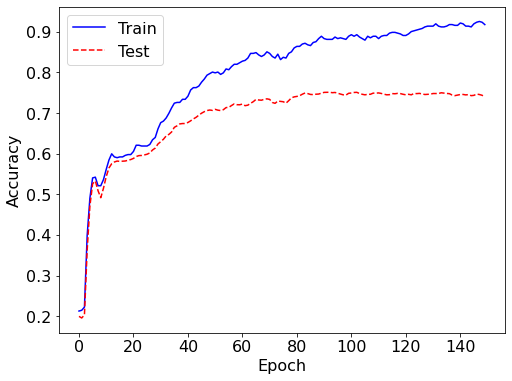

In [60]:
'''
To get an overview of the accuracy over the training period, we define a simple function
to plot the saved accuracies.
'''
%matplotlib inline
import matplotlib.pyplot as plt

def plot_train(train_accs, test_accs):
    fig, ax = plt.subplots(figsize=(8,6))
    fnt=16
    ax.plot(train_accs, color='blue', label='Train')
    ax.plot(test_accs, color='red', linestyle='--', label='Test')
    ax.legend(fontsize=fnt)
    ax.tick_params(axis='both', labelsize=fnt)
    ax.set_xlabel('Epoch', fontsize=fnt)
    ax.set_ylabel('Accuracy', fontsize=fnt)

plot_train(train_accs, test_accs)

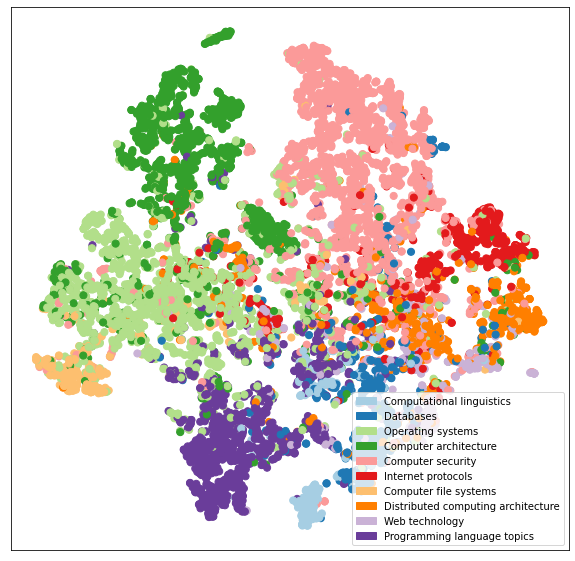

In [61]:
from sklearn.manifold import TSNE
from matplotlib import cm
from matplotlib.patches import Patch

'''
A function that plots a models embeddings, and colors them either according to 
the original labels or the predicted labels. Additionally, we can highlight 
individual datapoints in this embedding.
'''
def visualize(y=None, out=None, z=None, hl=None, text_type='idx', return_z=False, color_pred=False):
    if out is None and z is None:
        print('Must supply either model or TSNE output!')
        return
    if (y is None and out is None) or (y is None and color_pred is False):
        print('Must supply either y or calculate y from out!')
        return

    if z is None: # create our embedding if it was not provided
        z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    
    if y is None and color_pred is True:
        y = out.argmax(dim=1) # if no labels are provided, take the model's output
    
    # initialize our figure / plotting related settings
    fig, ax = plt.subplots()
    fig.set_size_inches((10, 10))
    
    ax.set_xticks([])
    ax.set_yticks([])

    colors = list(plt.cm.Paired.colors)[0:num_classes]
    labels = [idx_to_label[i] for i in range(num_classes)]
    
    c = [colors[i] for i in y]
    
    s=50
    scatter = ax.scatter(z[:, 0], z[:, 1], s=s, c=c)
            
    # create our legend
    handles = [Patch(color=c, label=l) for c, l in zip(colors, labels)]
    ax.legend(handles=handles)
    plt.show()

#label_to_idx = {num_class[i]: i for i in range(len(labels))}
idx_to_label = {i: data_metadata['labels'][str(i)] for i in range(num_classes)}

out = model_gnn(data_1.x, data_1.edge_index)  # get node embeddings from the GNN
z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())  # and create a TSNE visualization
visualize(z=z, y=data_1.y, hl=[10], text_type='title')

# Task 2

In [62]:
## Build the anomaly detection model ##
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc_input = nn.Linear(input_dim, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear (hidden_dim, latent_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_input(x))
        h = torch.relu(self.fc_hidden(h))
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        z = self.reparameterization(mu, log_sigma)

        return z, mu, log_sigma
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.rand_like(sigma).to(DEVICE)
        z = mu + sigma * epsilon
        
        return z
    
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden1(x))
        h = torch.relu(self.fc_hidden2(h))
        x_reconstr = torch.sigmoid(self.fc_output(h))
        return x_reconstr
    
    
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
                
    def forward(self, x):
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        
        return x_reconstr, mu, log_sigma

x_dim  = 300
hidden_dim = 500
latent_dim = 10  # NOTE: a 2-dimensional latent space allows for nice latent space plots, but is too low-dimensional to perform well in general

cuda = True  # NOTE: if running in Google Colab, make sure to go to "Edit > Notebook settings" and set "Hardware accelerator" to "GPU"
DEVICE = torch.device("cuda" if cuda else "cpu")

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

vae = VAE(encoder=encoder, decoder=decoder).to(DEVICE)

In [63]:
## Download the anomaly evaluation data ##
data_2 = download('https://surfdrive.surf.nl/files/index.php/s/EzMkh3SZbsbJb2i/download', filetype='tensor')
is_anomaly = download('https://surfdrive.surf.nl/files/index.php/s/wrK5xipcIC9DHhu/download', filetype='pickle')

In [64]:
total_node = data_2.x.shape[0]
total_edge = data_2.edge_index.shape[1]
new_node = total_node - num_node
new_edge = total_edge - num_edge
print(f'Num new nodes: {new_node}')
print(f'Num new edges: {new_edge}')

Num new nodes: 2000
Num new edges: 50176


In [65]:
print(f'Indices of new nodes are {num_node}...{total_node-1}')
print('The first 1000 are real articles, the last 1000 are anomaly articles')
print('You can use the map "is_anomaly" to identify whether a node is an anomaly or not')
e_real = num_node+500
e_anomaly = num_node+1500
print(f'E.g., is_anomaly[{e_real}] = {is_anomaly[e_real]} and is_anomaly[{e_anomaly}] = {is_anomaly[e_anomaly]}')

Indices of new nodes are 10701...12700
The first 1000 are real articles, the last 1000 are anomaly articles
You can use the map "is_anomaly" to identify whether a node is an anomaly or not
E.g., is_anomaly[11201] = 0 and is_anomaly[12201] = 1


In [66]:
train_dataset = TensorDataset(data_1.x[:10700], data_1.y[:10700])
test_dataset = TensorDataset(data_2.x, data_2.y)

batch_size = 100
kwargs = {'num_workers': 1, 'pin_memory': True} 
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, **kwargs)


# Get the corresponding indices
anomaly_indices_test = [i for i in range(10701, len(data_2.x)) if is_anomaly[i] == 1]
normal_indices_test = [i for i in range(len(data_2.x)) if i not in anomaly_indices_test]
# use a SubsetRandomSampler to sample only from the normal/anomaly dataset
anomaly_sampler_test = SubsetRandomSampler(anomaly_indices_test)
normal_sampler_test = SubsetRandomSampler(normal_indices_test)
# Setup the data in a dataset
test_dataset_normal = TensorDataset(data_2.x[10700:11700], data_2.y[10700:11700])
print(anomaly_indices_test)
test_dataset_anomaly = TensorDataset(data_2.x, data_2.y)
# Setup the dataloaders
anomaly_loader_test = DataLoader(dataset=test_dataset_anomaly, batch_size=batch_size, sampler=anomaly_sampler_test, **kwargs)
normal_loader_test = DataLoader(dataset=test_dataset_normal, batch_size=batch_size, **kwargs)

[11701, 11702, 11703, 11704, 11705, 11706, 11707, 11708, 11709, 11710, 11711, 11712, 11713, 11714, 11715, 11716, 11717, 11718, 11719, 11720, 11721, 11722, 11723, 11724, 11725, 11726, 11727, 11728, 11729, 11730, 11731, 11732, 11733, 11734, 11735, 11736, 11737, 11738, 11739, 11740, 11741, 11742, 11743, 11744, 11745, 11746, 11747, 11748, 11749, 11750, 11751, 11752, 11753, 11754, 11755, 11756, 11757, 11758, 11759, 11760, 11761, 11762, 11763, 11764, 11765, 11766, 11767, 11768, 11769, 11770, 11771, 11772, 11773, 11774, 11775, 11776, 11777, 11778, 11779, 11780, 11781, 11782, 11783, 11784, 11785, 11786, 11787, 11788, 11789, 11790, 11791, 11792, 11793, 11794, 11795, 11796, 11797, 11798, 11799, 11800, 11801, 11802, 11803, 11804, 11805, 11806, 11807, 11808, 11809, 11810, 11811, 11812, 11813, 11814, 11815, 11816, 11817, 11818, 11819, 11820, 11821, 11822, 11823, 11824, 11825, 11826, 11827, 11828, 11829, 11830, 11831, 11832, 11833, 11834, 11835, 11836, 11837, 11838, 11839, 11840, 11841, 11842, 11843

In [67]:
## Evaluate the anomaly detection model ##
lr = 1e-3

def loss_function(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

optimizer = Adam(vae.parameters(), lr=lr)

epochs = 100

print("Start training VAE...")
vae.train()

for epoch in range(epochs):
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_reconstr, mu, log_sigma = vae(x)
        loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
        
        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        
        loss.backward()
        optimizer.step()
        
    n_datapoints = batch_idx * batch_size
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints, "\tReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints)
    
print("Training complete!")

Start training VAE...
	Epoch 1 	Average Loss:  8.524005622144015 	Reconstruction Loss: 8.168501811477373 	KL Loss: 0.35550376659856653
	Epoch 2 	Average Loss:  4.185996658037293 	Reconstruction Loss: 4.176936423823519 	KL Loss: 0.009060225981586385
	Epoch 3 	Average Loss:  4.167463543010208 	Reconstruction Loss: 4.155972790987986 	KL Loss: 0.011490754811268933
	Epoch 4 	Average Loss:  4.165717900114239 	Reconstruction Loss: 4.150084622940927 	KL Loss: 0.015633268862400414
	Epoch 5 	Average Loss:  4.161170161985002 	Reconstruction Loss: 4.14179869453862 	KL Loss: 0.01937148171775746
	Epoch 6 	Average Loss:  4.159342392255675 	Reconstruction Loss: 4.137582869619694 	KL Loss: 0.02175951728280985
	Epoch 7 	Average Loss:  4.157195287740455 	Reconstruction Loss: 4.134488082022037 	KL Loss: 0.022707202085908852
	Epoch 8 	Average Loss:  4.157592209150207 	Reconstruction Loss: 4.134122628265956 	KL Loss: 0.02346958230126579
	Epoch 9 	Average Loss:  4.157248224222435 	Reconstruction Loss: 4.1329

100%|██████████| 10/10 [00:00<00:00, 92.30it/s]


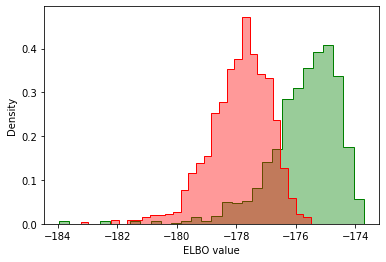

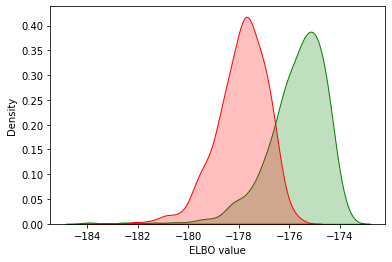

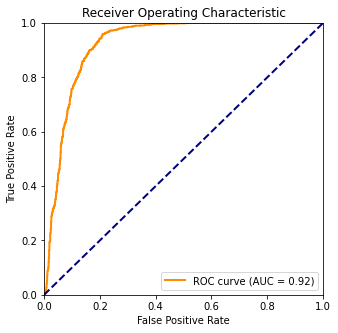

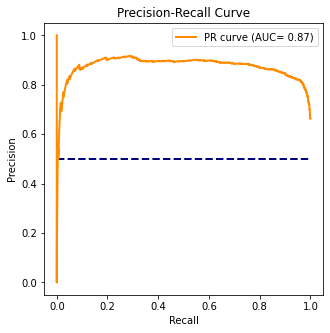

In [68]:
def elbo_elementwise(x, x_reconstr, mu, log_sigma):
    reconstr_loss = torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=1)
    constant_term = x_dim * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
    elbo = - reconstr_loss - constant_term - kl_loss
    return elbo, reconstr_loss, kl_loss

vae.eval()

x_original_list_normal = []
x_reconstr_list_normal = []
elbos_normal = []
x_original_list_anomaly = []
x_reconstr_list_anomaly = []
elbos_anomaly = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(tqdm(normal_loader_test)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_reconstr, mu, log_sigma = vae(x)
        elbo, reconstr_loss, kl_loss = elbo_elementwise(x, x_reconstr, mu, log_sigma)

        x_original_list_normal.append(x)
        x_reconstr_list_normal.append(x_reconstr)
        elbos_normal.append(elbo.cpu().numpy())
    
    for batch_idx, (x, y) in enumerate(tqdm(anomaly_loader_test)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_reconstr, mu, log_sigma = vae(x)
        elbo, reconstr_loss, kl_loss = elbo_elementwise(x, x_reconstr, mu, log_sigma)

        x_original_list_anomaly.append(x)
        x_reconstr_list_anomaly.append(x_reconstr)
        elbos_anomaly.append(elbo.cpu().numpy())

elbos_normal = np.concatenate(elbos_normal)  # loss values represent *negative* ELBO values
elbos_anomaly = np.concatenate(elbos_anomaly)

def density_histogram(neg, pos, bins=30, alpha=0.4):
    plt.figure()
    plt.hist(neg, bins=bins, density=True, histtype="bar", color="g", alpha=alpha)
    plt.hist(neg, bins=bins, density=True, histtype="step", color="g", alpha=1)
    plt.hist(pos, bins=bins, density=True, histtype="bar", color="r", alpha=alpha)
    plt.hist(pos, bins=bins, density=True, histtype="step", color="r", alpha=1)
    plt.xlabel("ELBO value")
    plt.ylabel("Density")
    plt.show()


def density_plot(neg, pos):
    plt.figure()
    sns.kdeplot(neg, shade=True, color="g")
    sns.kdeplot(pos, shade=True, color="r")
    plt.xlabel("ELBO value")
    plt.ylabel("Density")

density_histogram(elbos_normal, elbos_anomaly)
density_plot(elbos_normal, elbos_anomaly)

def roc_pr_curves(neg, pos):
    # translate to scores from 0 to 1, where 1 means anomaly (low ELBO) and 0 means normal (high ELBO)
    min_val = min(np.min(neg), np.min(pos))
    max_val = max(np.max(neg), np.max(pos))
    y_true_neg = np.zeros(neg.shape)
    y_true_pos = np.ones(pos.shape)
    y_true = np.concatenate((y_true_neg, y_true_pos))
    y_score = (max_val - np.concatenate((neg, pos))) / (max_val - min_val)

    # get ROC curve values
    fpr, tpr, _ = roc_curve(y_true, y_score, drop_intermediate=True)
    auroc = auc(fpr, tpr)

    # plot ROC curve
    lw = 2
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % auroc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # get Precision-Recall values
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auprc = auc(recall, precision)

    # plot Precision-Recall curve
    no_skill = len(y_true[y_true==1]) / len(y_true)
    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [no_skill, no_skill], color="navy", lw=lw, linestyle='--')
    plt.plot(recall, precision, color='darkorange',
             lw=lw, label="PR curve (AUC= %0.2f)" % auprc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision-Recall Curve")
    plt.legend(loc="upper right")
    plt.show()

roc_pr_curves(elbos_normal, elbos_anomaly)